In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sum
import matplotlib.pyplot as plt

from datetime import datetime
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.api import VAR
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

In [4]:
!curl -o raw_data/temperature.csv https://lazyprogrammer.me/course_files/timeseries/temperature.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
  3 3980k    3  134k    0     0  72629      0  0:00:56  0:00:01  0:00:55 72740
 14 3980k   14  574k    0     0   202k      0  0:00:19  0:00:02  0:00:17  203k
 28 3980k   28 1134k    0     0   290k      0  0:00:13  0:00:03  0:00:10  290k
 48 3980k   48 1934k    0     0   388k      0  0:00:10  0:00:04  0:00:06  388k
 71 3980k   71 2846k    0     0   488k      0  0:00:08  0:00:05  0:00:03  634k
 95 3980k   95 3790k    0     0   545k      0  0:00:07  0:00:06  0:00:01  723k
100 3980k  100 3980k    0     0   561k      0  0:00:07  0:00:07 --:--:--  799k


In [3]:
data = pd.read_csv('raw_data/temperature.csv')
data

,record_id,month,day,year,AverageTemperatureFahr,AverageTemperatureUncertaintyFahr,City,country_id,Country,Latitude,Longitude
0,474376,1,1,1853,NaN,NaN,Auckland,NEW,New Zealand,36.17S,175.03E
1,474377,2,1,1853,NaN,NaN,Auckland,NEW,New Zealand,36.17S,175.03E
2,474378,3,1,1853,NaN,NaN,Auckland,NEW,New Zealand,36.17S,175.03E
3,474379,4,1,1853,NaN,NaN,Auckland,NEW,New Zealand,36.17S,175.03E
4,474380,5,1,1853,NaN,NaN,Auckland,NEW,New Zealand,36.17S,175.03E
...,...,...,...,...,...,...,...,...,...,...,...
48465,8258726,5,1,2013,55.0544,32.4896,Wroclaw,POL,Poland,50.63N,16.48E
48466,8258727,6,1,2013,61.1672,32.3330,Wroclaw,POL,Poland,50.63N,16.48E
48467,8258728,7,1,2013,66.7706,32.5706,Wroclaw,POL,Poland,50.63N,16.48E
48468,8258729,8,1,2013,64.5656,32.4842,Wroclaw,POL,Poland,50.63N,16.48E


In [4]:
def parse_date(row):
    s = f"{row['year']}-{row['month']}-{row['day']}"
    return datetime.strptime(s, "%Y-%m-%d")

In [5]:
data["Date"] = data.apply(parse_date, axis=1)
data

,record_id,month,day,year,AverageTemperatureFahr,AverageTemperatureUncertaintyFahr,City,country_id,Country,Latitude,Longitude,Date
0,474376,1,1,1853,NaN,NaN,Auckland,NEW,New Zealand,36.17S,175.03E,1853-01-01
1,474377,2,1,1853,NaN,NaN,Auckland,NEW,New Zealand,36.17S,175.03E,1853-02-01
2,474378,3,1,1853,NaN,NaN,Auckland,NEW,New Zealand,36.17S,175.03E,1853-03-01
3,474379,4,1,1853,NaN,NaN,Auckland,NEW,New Zealand,36.17S,175.03E,1853-04-01
4,474380,5,1,1853,NaN,NaN,Auckland,NEW,New Zealand,36.17S,175.03E,1853-05-01
...,...,...,...,...,...,...,...,...,...,...,...,...
48465,8258726,5,1,2013,55.0544,32.4896,Wroclaw,POL,Poland,50.63N,16.48E,2013-05-01
48466,8258727,6,1,2013,61.1672,32.3330,Wroclaw,POL,Poland,50.63N,16.48E,2013-06-01
48467,8258728,7,1,2013,66.7706,32.5706,Wroclaw,POL,Poland,50.63N,16.48E,2013-07-01
48468,8258729,8,1,2013,64.5656,32.4842,Wroclaw,POL,Poland,50.63N,16.48E,2013-08-01


In [6]:
auckland = data[data["City"] == "Auckland"].copy().dropna()
stockholm = data[data["City"] == "Stockholm"].copy().dropna()

In [7]:
auckland = auckland[["Date", "AverageTemperatureFahr"]].copy()
stockholm = stockholm[["Date", "AverageTemperatureFahr"]].copy()

In [8]:
auckland.set_index(auckland["Date"], inplace=True)
auckland.drop("Date", axis=1, inplace=True)
auckland.columns = ["AucklandTemp"]

In [9]:
auckland

,AucklandTemp
Date,
1853-06-01,51.9062
1853-07-01,52.3886
1853-08-01,52.8530
1853-09-01,52.5776
1853-10-01,54.8726
...,...
2013-04-01,64.1102
2013-05-01,59.5004
2013-06-01,56.2100


In [10]:
stockholm.set_index(stockholm["Date"], inplace=True)
stockholm.drop("Date", axis=1, inplace=True)
stockholm.columns = ["StockholmTemp"]
stockholm

,StockholmTemp
Date,
1743-11-01,42.8414
1744-04-01,36.8888
1744-05-01,45.1220
1744-06-01,53.1824
1744-07-01,60.0260
...,...
2013-04-01,36.8096
2013-05-01,51.3428
2013-06-01,57.7544


In [11]:
joined = auckland.join(stockholm, how="outer")

In [13]:
joined.shape

(3155, 2)

In [39]:
joined_part = joined.iloc[-50:].copy()
joined_part.index.freq = "MS"

In [40]:
joined_part.isna().sum()

AucklandTemp     0
StockholmTemp    0
dtype: int64

In [41]:
joined_part.interpolate(inplace=True)

In [42]:
joined_part.isna().sum()

AucklandTemp     0
StockholmTemp    0
dtype: int64

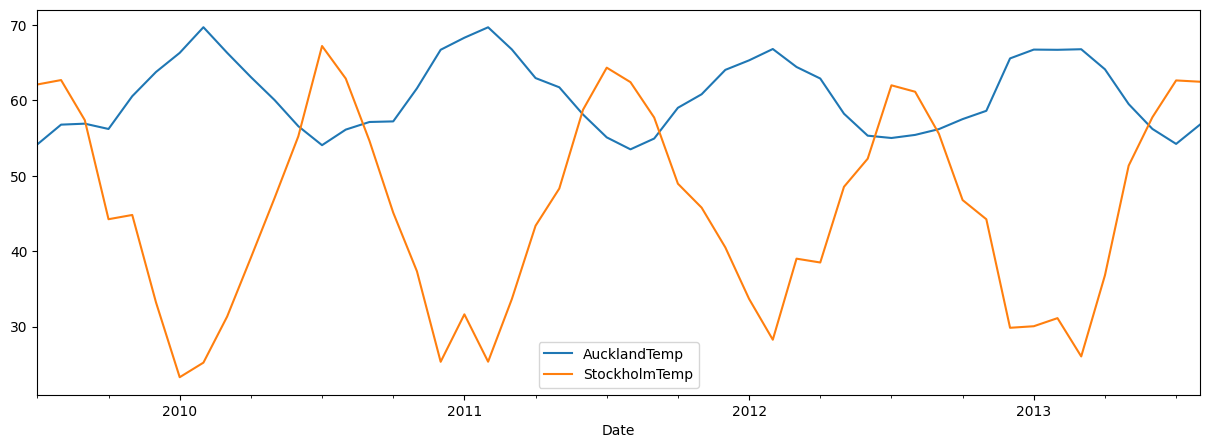

In [43]:
joined_part.plot(figsize=(15, 5));

In [44]:
Ntest = 12
train = joined_part.iloc[:-Ntest].copy()
test = joined_part.iloc[-Ntest:].copy()

In [45]:
scaler_auckland = StandardScaler()
train["ScaledAuckland"] = scaler_auckland.fit_transform(train[["AucklandTemp"]])
test["ScaledAuckland"] = scaler_auckland.transform(test[["AucklandTemp"]])

In [46]:
scaler_stockholm = StandardScaler()
train["ScaledStockholm"] = scaler_stockholm.fit_transform(train[["StockholmTemp"]])
test["ScaledStockholm"] = scaler_stockholm.transform(test[["StockholmTemp"]])

In [47]:
train_idx = joined_part.index <= train.index[-1]
test_idx = joined_part.index > train.index[-1]

In [48]:
joined_part.loc[train_idx, "ScaledAuckland"] = train["ScaledAuckland"]
joined_part.loc[test_idx, "ScaledAuckland"] = test["ScaledAuckland"]
joined_part.loc[train_idx, "ScaledStockholm"] = train["ScaledStockholm"]
joined_part.loc[test_idx, "ScaledStockholm"] = test["ScaledStockholm"]

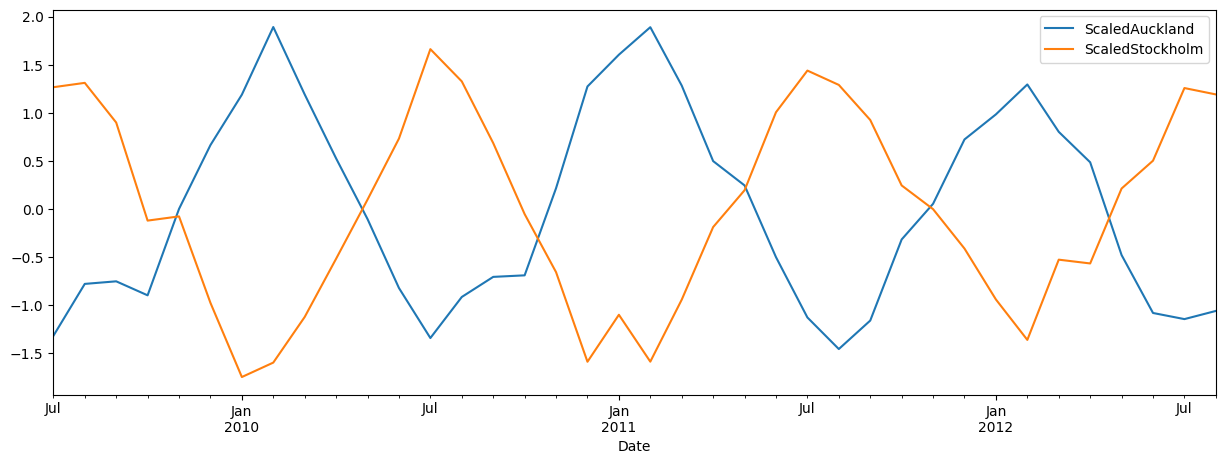

In [49]:
cols = ["ScaledAuckland", "ScaledStockholm"]
train[cols].plot(figsize=(15, 5));

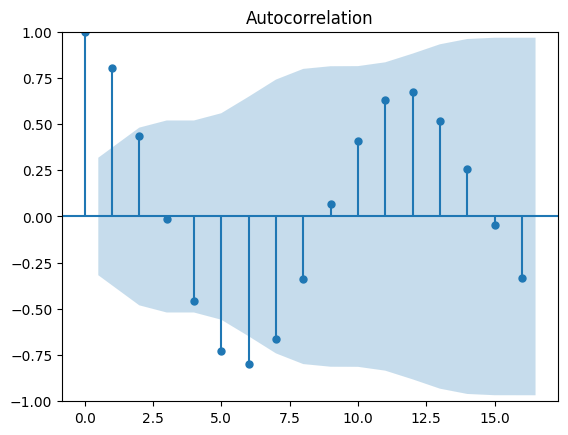

In [50]:
plot_acf(train["ScaledAuckland"]);

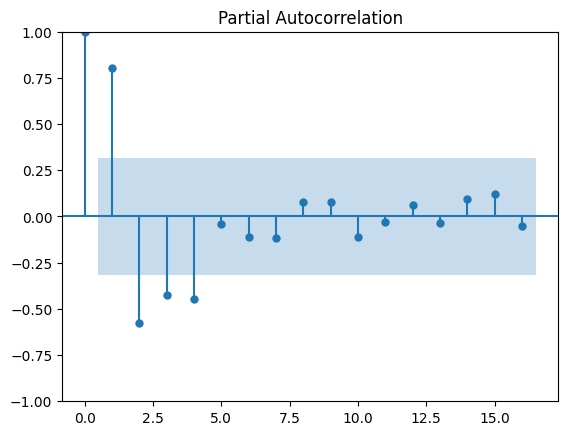

In [51]:
plot_pacf(train["ScaledAuckland"]);

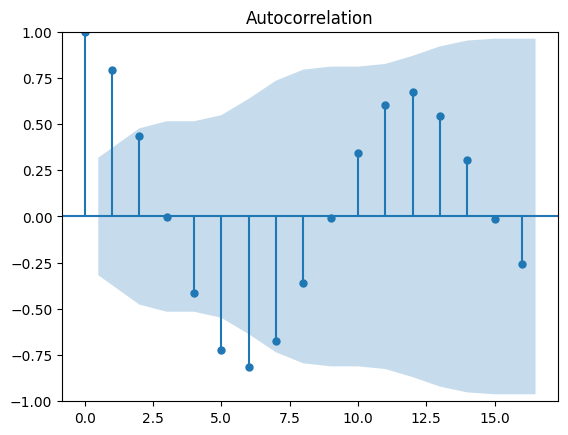

In [52]:
plot_acf(train["ScaledStockholm"]);

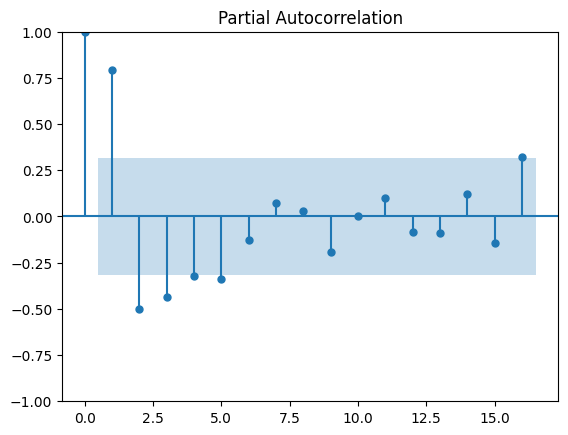

In [53]:
plot_pacf(train["ScaledStockholm"]);

In [56]:
t0 = datetime.now()
model = VARMAX(train[cols], order=(2, 2))
res = model.fit(maxiter=100)
print("Dration:", datetime.now() - t0)

c:\All Python Projects\Interpreters\in_Machine_Learning\Lib\site-packages\statsmodels\tsa\statespace\varmax.py:160: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'


Dration: 0:00:10.602301


c:\All Python Projects\Interpreters\in_Machine_Learning\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [57]:
fcast = res.get_forecast(Ntest)

In [58]:
res.fittedvalues["ScaledAuckland"]

Date
2009-07-01    0.077145
2009-08-01   -1.122137
2009-09-01   -0.570152
2009-10-01   -0.480386
2009-11-01   -0.086934
2009-12-01    0.608074
2010-01-01    1.115551
2010-02-01    1.544930
2010-03-01    1.649322
2010-04-01    0.639439
2010-05-01   -0.006541
2010-06-01   -0.611606
2010-07-01   -1.030910
2010-08-01   -1.411936
2010-09-01   -0.723943
2010-10-01   -0.359243
2010-11-01    0.027922
2010-12-01    0.873362
2011-01-01    1.688487
2011-02-01    1.405612
2011-03-01    1.372326
2011-04-01    0.469067
2011-05-01   -0.345591
2011-06-01   -0.534795
2011-07-01   -1.180611
2011-08-01   -1.441050
2011-09-01   -1.303841
2011-10-01   -0.612523
2011-11-01    0.285981
2011-12-01    0.552756
2012-01-01    0.970112
2012-02-01    0.995469
2012-03-01    1.151345
2012-04-01    0.271992
2012-05-01    0.070582
2012-06-01   -0.816658
2012-07-01   -0.933417
2012-08-01   -0.961311
Freq: MS, Name: ScaledAuckland, dtype: float64

In [60]:
joined_part.loc[train_idx, "Train Pred Auckland"] = res.fittedvalues["ScaledAuckland"]
joined_part.loc[test_idx, "Test Pred Auckland"] = fcast.predicted_mean["ScaledAuckland"]

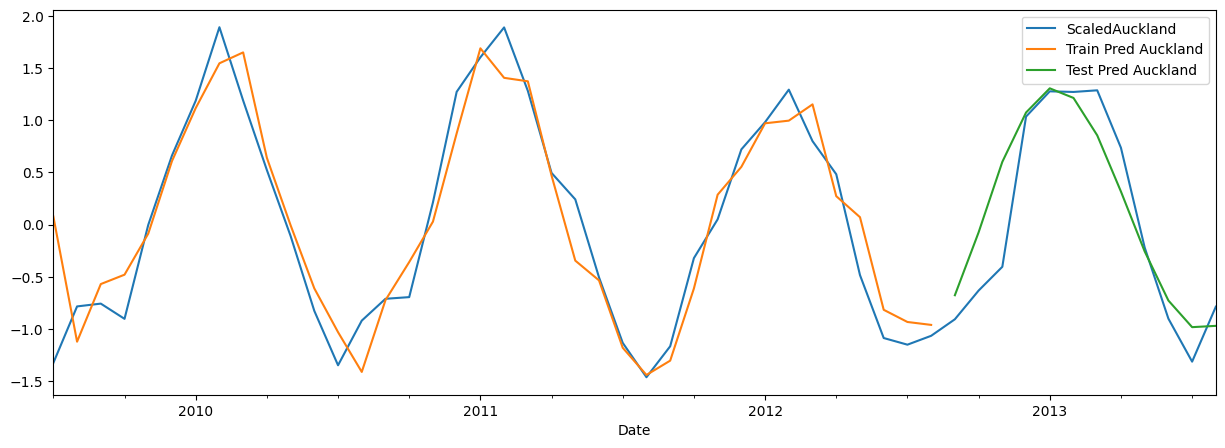

In [61]:
plot_cols = ["ScaledAuckland", "Train Pred Auckland", "Test Pred Auckland"]
joined_part[plot_cols].plot(figsize=(15, 5));

In [63]:
joined_part.loc[train_idx, "Train Pred Stockholm"] = res.fittedvalues["ScaledStockholm"]
joined_part.loc[test_idx, "Test Pred Stockholm"] = fcast.predicted_mean["ScaledStockholm"]


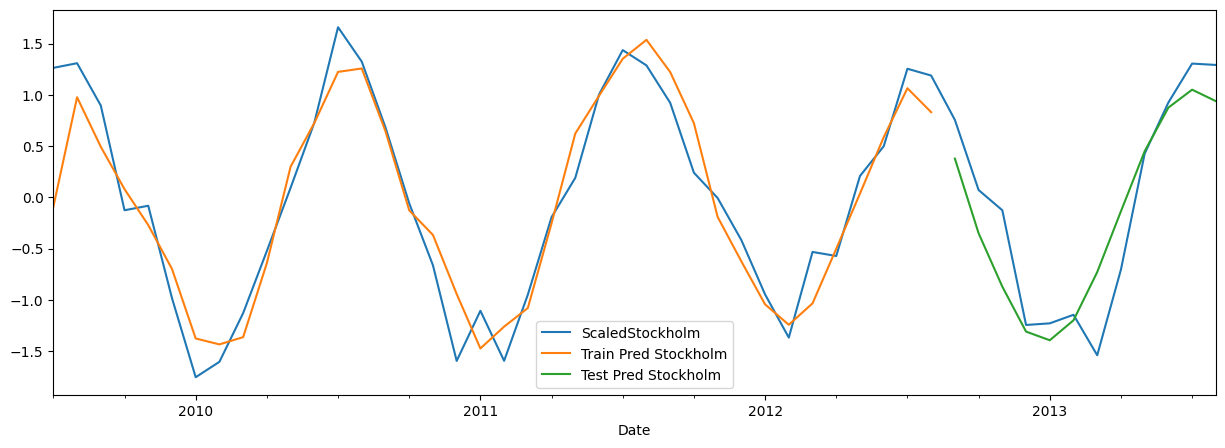

In [64]:
plot_cols = ["ScaledStockholm", "Train Pred Stockholm", "Test Pred Stockholm"]
joined_part.iloc[-100:][plot_cols].plot(figsize=(15, 5));

In [74]:
y_pred = joined_part.loc[train_idx, "Train Pred Auckland"]
y_true = joined_part.loc[train_idx, "ScaledAuckland"]
print("Auckland Train R2:", r2_score(y_true, y_pred))

y_pred = joined_part.loc[test_idx, "Test Pred Auckland"]
y_true = joined_part.loc[test_idx, "ScaledAuckland"]
print("Auckland Test R2:", r2_score(y_true, y_pred))

Auckland Train R2: 0.8725805549457664
Auckland Test R2: 0.8270155690149921


In [75]:
y_pred = joined_part.loc[train_idx, "Train Pred Stockholm"]
y_true = joined_part.loc[train_idx, "ScaledStockholm"]
print("Stockholm Train R2:", r2_score(y_true, y_pred))

y_pred = joined_part.loc[test_idx, "Test Pred Stockholm"]
y_true = joined_part.loc[test_idx, "ScaledStockholm"]
print("Stockholm Test R2:", r2_score(y_true, y_pred))

Stockholm Train R2: 0.8770494019951384
Stockholm Test R2: 0.8280539382688645


## VAR

In [76]:
model = VAR(train[cols])

In [78]:
lag_order_results = model.select_order(maxlags=10)
lag_order_results

In [80]:
lag_order_results.selected_orders

{'aic': 10, 'bic': 10, 'hqic': 10, 'fpe': 10}

In [81]:
results = model.fit(maxlags=10, ic="aic")

In [83]:
lag_order = results.k_ar
lag_order

10

In [84]:
prior = train.iloc[-lag_order:][cols].to_numpy()
fcast = results.forecast(prior, Ntest)

In [86]:
joined_part.loc[train_idx, "Train Pred Auckland"] = results.fittedvalues["ScaledAuckland"]
joined_part.loc[test_idx, "Test Pred Auckland"] = fcast[:, 0]

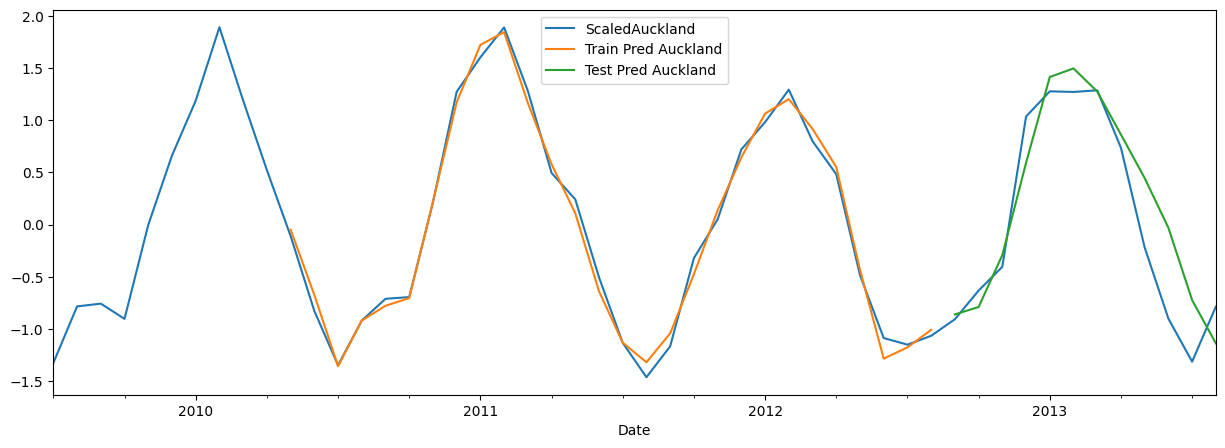

In [88]:
plot_cols = ["ScaledAuckland", "Train Pred Auckland", "Test Pred Auckland"]
joined_part[plot_cols].plot(figsize=(15, 5));

In [89]:
joined_part.loc[train_idx, "Train Pred Stockholm"] = results.fittedvalues["ScaledStockholm"]
joined_part.loc[test_idx, "Test Pred Stockholm"] = fcast[:, 0]

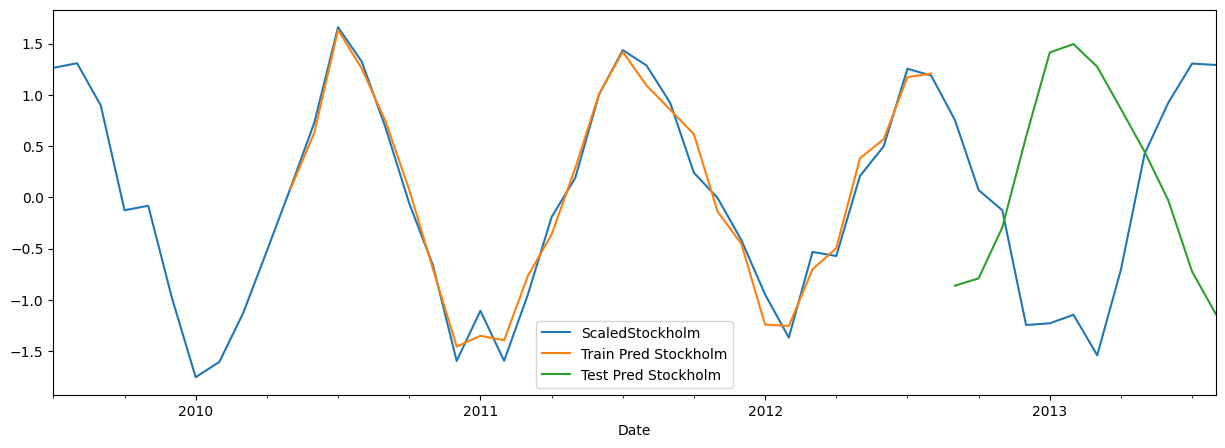

In [90]:
plot_cols = ["ScaledStockholm", "Train Pred Stockholm", "Test Pred Stockholm"]
joined_part[plot_cols].plot(figsize=(15, 5));

In [91]:
y_pred = joined_part.loc[train_idx, "Train Pred Auckland"]
y_true = joined_part.loc[train_idx, "ScaledAuckland"]
y_pred = y_pred.iloc[lag_order:]
y_true = y_true.iloc[lag_order:]
print("Auckland Train R2:", r2_score(y_true, y_pred))

y_pred = joined_part.loc[test_idx, "Test Pred Auckland"]
y_true = joined_part.loc[test_idx, "ScaledAuckland"]
print("Auckland Test R2:", r2_score(y_true, y_pred))


Auckland Train R2: 0.9901513580549097
Auckland Test R2: 0.820334052761898


In [92]:
y_pred = joined_part.loc[train_idx, "Train Pred Stockholm"]
y_true = joined_part.loc[train_idx, "ScaledStockholm"]
y_pred = y_pred.iloc[lag_order:]
y_true = y_true.iloc[lag_order:]
print("Stockholm Train R2:", r2_score(y_true, y_pred))

y_pred = joined_part.loc[test_idx, "Test Pred Stockholm"]
y_true = joined_part.loc[test_idx, "ScaledStockholm"]
print("Stockholm Test R2:", r2_score(y_true, y_pred))

Stockholm Train R2: 0.9761500572447536
Stockholm Test R2: -2.467632096131053


## ARIMA Baseline

In [93]:
from statsmodels.tsa.arima.model import ARIMA

In [95]:
for col in cols:
    model = ARIMA(train[col], order=(10, 0, 10)) # should be like VARMA
    res = model.fit()
    fcast = res.get_forecast(Ntest)
    print(f"{col} Train R2: {r2_score(joined_part.loc[train_idx, col], res.fittedvalues)}")
    print(f"{col} Test R2: {r2_score(joined_part.loc[test_idx, col], fcast.predicted_mean)}")


c:\All Python Projects\Interpreters\in_Machine_Learning\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\All Python Projects\Interpreters\in_Machine_Learning\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\All Python Projects\Interpreters\in_Machine_Learning\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


ScaledAuckland Train R2: 0.888285169602402
ScaledAuckland Test R2: 0.8481075014070026
ScaledStockholm Train R2: 0.8958888526802001
ScaledStockholm Test R2: 0.9180365040440036


c:\All Python Projects\Interpreters\in_Machine_Learning\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

In [5]:
!curl -o raw_data/us_macro_quarterly.xlsx https://lazyprogrammer.me/course_files/timeseries/us_macro_quarterly.xlsx

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
 22 76805   22 17056    0     0  14087      0  0:00:05  0:00:01  0:00:04 14154
100 76805  100 76805    0     0  57610      0  0:00:01  0:00:01 --:--:-- 57835


In [55]:
data = pd.read_excel("raw_data/us_macro_quarterly.xlsx")
data = data[-75:]

c:\All Python Projects\Interpreters\in_Machine_Learning\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [56]:
def parse_date(data):
    year, quarter = data.split(":")
    month = (int(quarter) - 1) * 3 + 1
    s = f"{year}-{month}"
    return datetime.strptime(s, "%Y-%m")

In [57]:
data["Date"] = data["Unnamed: 0"].apply(parse_date)

In [58]:
data

,Unnamed: 0,GDPC96,JAPAN_IP,PCECTPI,GS10,GS1,TB3MS,UNRATE,EXUSUK,CPIAUCSL,Date
153,1995:02,10111.126,99.320282,76.224,6.620000,5.970000,5.596667,5.666667,1.596500,152.100000,1995-04-01
154,1995:03,10197.669,97.772519,76.530,6.323333,5.653333,5.366667,5.666667,1.573667,152.866667,1995-07-01
155,1995:04,10270.057,99.649593,76.867,5.893333,5.443333,5.260000,5.566667,1.560300,153.700000,1995-10-01
156,1996:01,10337.435,99.188558,77.298,5.910000,5.123333,4.930000,5.533333,1.530633,155.066667,1996-01-01
157,1996:02,10517.932,99.847180,77.809,6.720000,5.663333,5.020000,5.500000,1.524267,156.400000,1996-04-01
...,...,...,...,...,...,...,...,...,...,...,...
223,2012:04,15539.628,94.258812,106.622,1.706667,0.173333,0.086667,7.833333,1.606433,231.277000,2012-10-01
224,2013:01,15583.948,94.725440,106.909,1.950000,0.153333,0.086667,7.700000,1.550633,232.102667,2013-01-01
225,2013:02,15679.677,95.992001,106.878,1.996667,0.126667,0.050000,7.500000,1.536700,232.086667,2013-04-01
226,2013:03,15839.347,97.558537,107.387,2.710000,0.123333,0.033333,7.233333,1.552300,233.597000,2013-07-01


In [59]:
data.set_index("Date", inplace=True)
data.drop(["Unnamed: 0"], axis=1, inplace=True)

In [60]:
data

,GDPC96,JAPAN_IP,PCECTPI,GS10,GS1,TB3MS,UNRATE,EXUSUK,CPIAUCSL
Date,,,,,,,,,
1995-04-01,10111.126,99.320282,76.224,6.620000,5.970000,5.596667,5.666667,1.596500,152.100000
1995-07-01,10197.669,97.772519,76.530,6.323333,5.653333,5.366667,5.666667,1.573667,152.866667
1995-10-01,10270.057,99.649593,76.867,5.893333,5.443333,5.260000,5.566667,1.560300,153.700000
1996-01-01,10337.435,99.188558,77.298,5.910000,5.123333,4.930000,5.533333,1.530633,155.066667
1996-04-01,10517.932,99.847180,77.809,6.720000,5.663333,5.020000,5.500000,1.524267,156.400000
...,...,...,...,...,...,...,...,...,...
2012-10-01,15539.628,94.258812,106.622,1.706667,0.173333,0.086667,7.833333,1.606433,231.277000
2013-01-01,15583.948,94.725440,106.909,1.950000,0.153333,0.086667,7.700000,1.550633,232.102667
2013-04-01,15679.677,95.992001,106.878,1.996667,0.126667,0.050000,7.500000,1.536700,232.086667


In [61]:
data.index.freq = "QS"

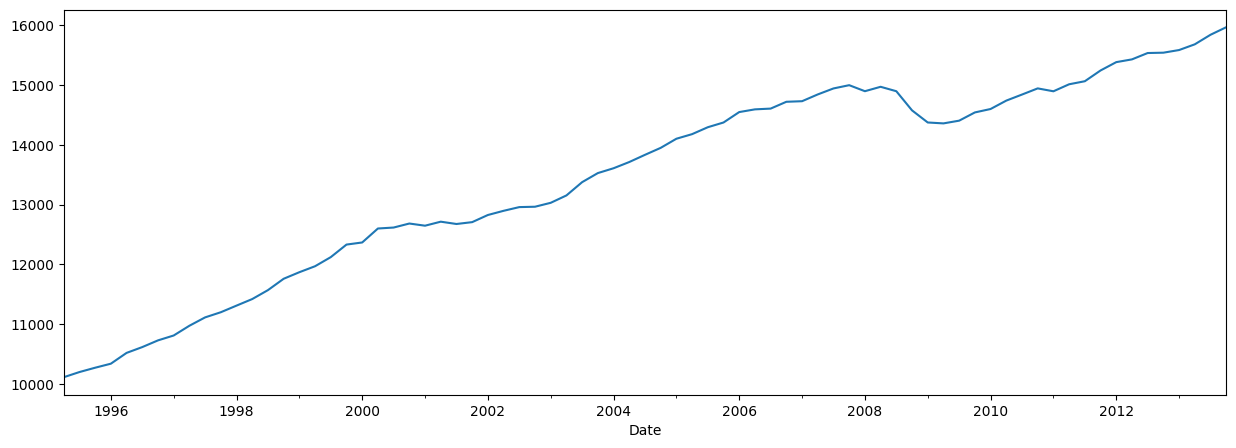

In [62]:
data["GDPC96"].plot(figsize=(15, 5));

In [63]:
data["GDPGrowth"] = np.log(data["GDPC96"]).diff()

In [64]:
data["TSpread"] = data["GS10"] - data["TB3MS"]

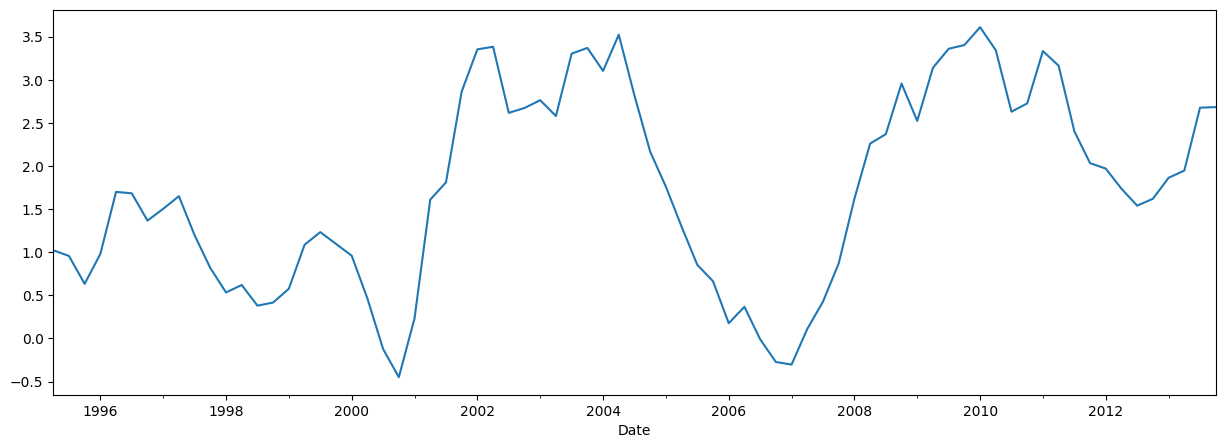

In [65]:
data["TSpread"].plot(figsize=(15, 5));

In [66]:
cols = ["GDPGrowth", "TSpread"]

In [67]:
data1 = data.iloc[1:][cols].copy()
data1

,GDPGrowth,TSpread
Date,,
1995-07-01,0.008523,0.956667
1995-10-01,0.007073,0.633333
1996-01-01,0.006539,0.980000
1996-04-01,0.017310,1.700000
1996-07-01,0.009207,1.683333
...,...,...
2012-10-01,0.000363,1.620000
2013-01-01,0.002848,1.863333
2013-04-01,0.006124,1.946667


In [68]:
Ntest = 12
train = data1.iloc[:-Ntest].copy()
test = data1.iloc[-Ntest:].copy()


In [69]:
train_idx = data1.index <= train.index[-1]
test_idx = ~train_idx

In [70]:
scaler = StandardScaler()
train[cols] = scaler.fit_transform(train)
test[cols] = scaler.transform(test)

In [71]:
data1.loc[train_idx, :] = train
data1.loc[test_idx, :] = test

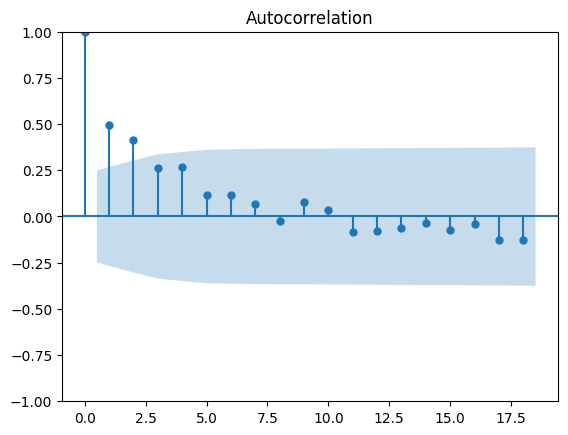

In [72]:
plot_acf(train["GDPGrowth"]);

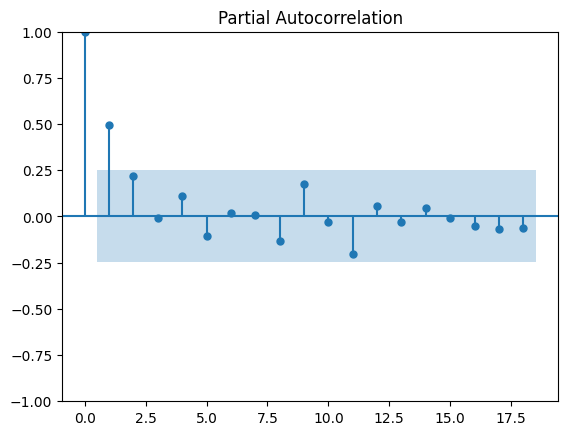

In [73]:
plot_pacf(train["GDPGrowth"]);

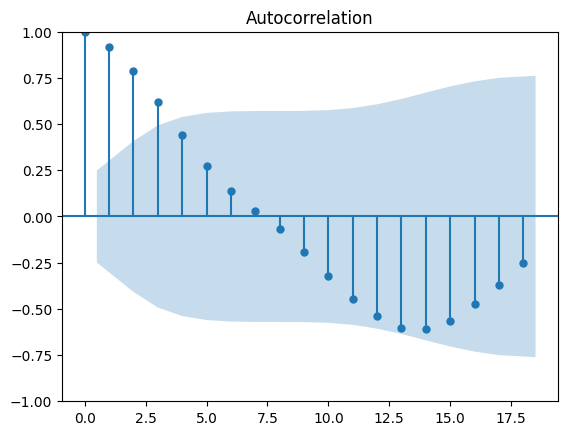

In [74]:
plot_acf(train["TSpread"]);

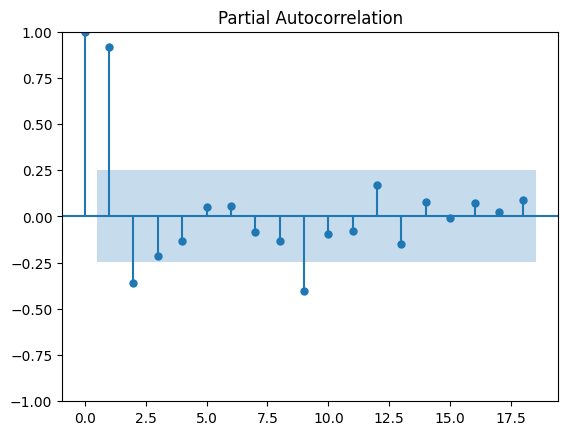

In [75]:
plot_pacf(train["TSpread"]);

In [76]:
adfuller(train["GDPGrowth"])

(-3.033457310054974,
 0.031885852141925776,
 1,
 60,
 {'1%': -3.5443688564814813,
  '5%': -2.9110731481481484,
  '10%': -2.5931902777777776},
 136.96810296038728)

In [77]:
adfuller(train["TSpread"])

(-3.6822650902559406,
 0.004369641038019896,
 8,
 53,
 {'1%': -3.560242358792829,
  '5%': -2.9178502070837,
  '10%': -2.5967964150943397},
 37.156981534329034)

In [78]:
p = 18
q = 1

In [79]:
t0 = datetime.now()
model = VARMAX(train, order=(p, q))
print("step1")
res = model.fit(maxiter=10)
print(f"Duration: {datetime.now() - t0} sec")

c:\All Python Projects\Interpreters\in_Machine_Learning\Lib\site-packages\statsmodels\tsa\statespace\varmax.py:160: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
c:\All Python Projects\Interpreters\in_Machine_Learning\Lib\site-packages\statsmodels\tsa\statespace\varmax.py:373: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


step1


c:\All Python Projects\Interpreters\in_Machine_Learning\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Duration: 0:00:16.029689 sec


In [80]:
fcast = res.get_forecast(Ntest)

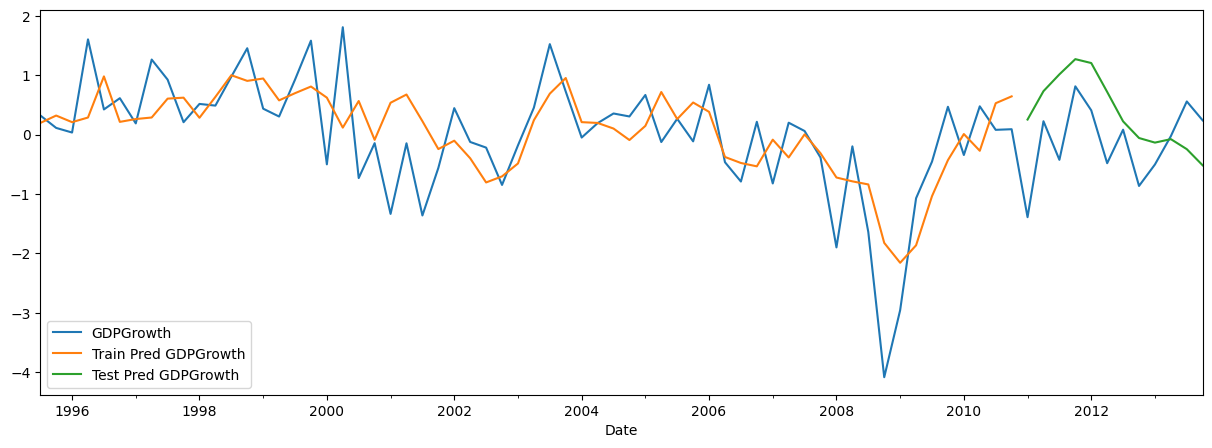

In [81]:
data1.loc[train_idx, "Train Pred GDPGrowth"] = res.fittedvalues["GDPGrowth"]
data1.loc[test_idx, "Test Pred GDPGrowth"] = fcast.predicted_mean["GDPGrowth"]
plot_cols = ["GDPGrowth", "Train Pred GDPGrowth", "Test Pred GDPGrowth"]
data1.iloc[-100:][plot_cols].plot(figsize=(15, 5));

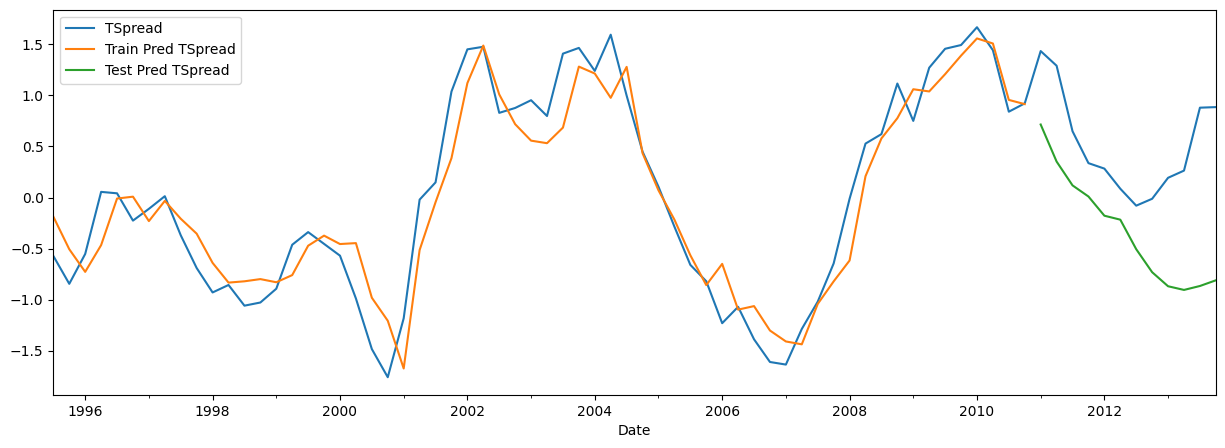

In [82]:
data1.loc[train_idx, "Train Pred TSpread"] = res.fittedvalues["TSpread"]
data1.loc[test_idx, "Test Pred TSpread"] = fcast.predicted_mean["TSpread"]
plot_cols = ["TSpread", "Train Pred TSpread", "Test Pred TSpread"]
data1.iloc[-100:][plot_cols].plot(figsize=(15, 5));

In [83]:
for col in cols:
    y_true = data1.loc[train_idx, col]
    y_pred = res.fittedvalues[col]
    print("Train R^2:", r2_score(y_true, y_pred))

    y_true = data1.loc[test_idx, col]
    y_pred = fcast.predicted_mean[col]
    print("Test R^2:", r2_score(y_true, y_pred))

Train R^2: 0.4575289741667472
Test R^2: -1.101106917495711
Train R^2: 0.9061524164499244
Test R^2: -2.9993171503548224


In [84]:
model = VAR(train)

In [87]:
lag_order_results = model.select_order(maxlags=10)
lag_order_results.selected_orders

{'aic': 2, 'bic': 1, 'hqic': 1, 'fpe': 2}

In [88]:
results = model.fit(maxlags=10, ic="aic")

In [89]:
lag_order = results.k_ar

In [90]:
prior = train.iloc[-lag_order:][cols].to_numpy()
fcast = results.forecast(prior, Ntest)

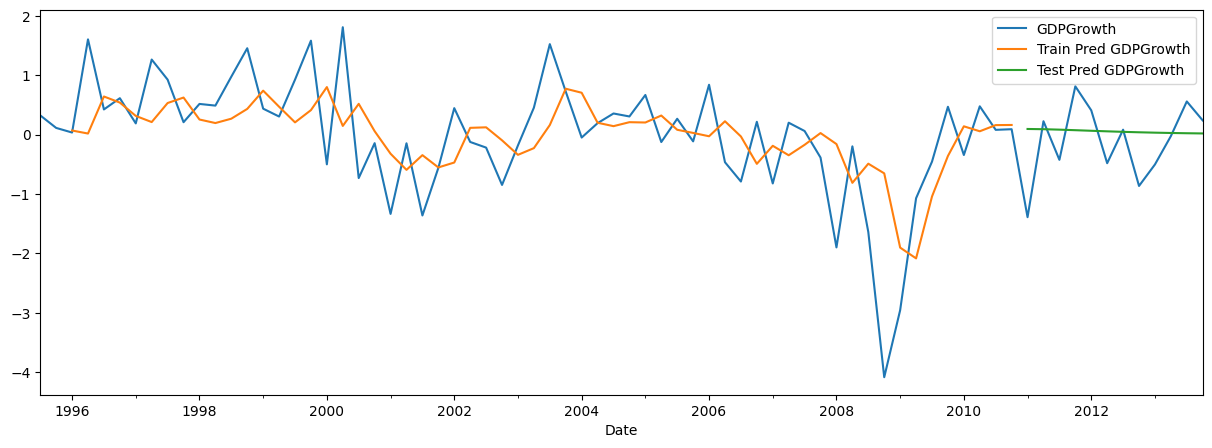

In [91]:
data1.loc[train_idx, "Train Pred GDPGrowth"] = results.fittedvalues["GDPGrowth"]
data1.loc[test_idx, "Test Pred GDPGrowth"] = fcast[:, 0]
plot_cols = ["GDPGrowth", "Train Pred GDPGrowth", "Test Pred GDPGrowth"]
data1.iloc[-100:][plot_cols].plot(figsize=(15, 5));

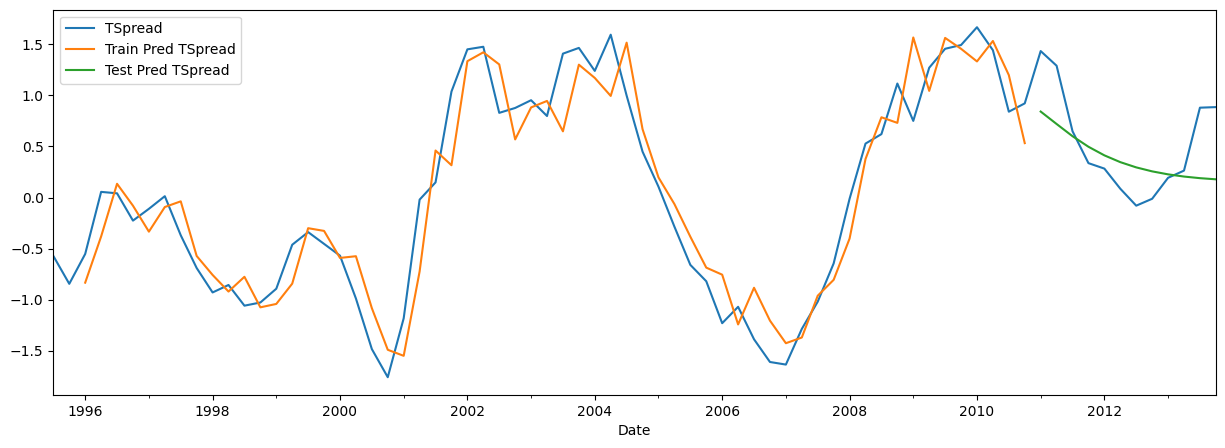

In [92]:
data1.loc[train_idx, "Train Pred TSpread"] = results.fittedvalues["TSpread"]
data1.loc[test_idx, "Test Pred TSpread"] = fcast[:, 1]
plot_cols = ["TSpread", "Train Pred TSpread", "Test Pred TSpread"]
data1.iloc[-100:][plot_cols].plot(figsize=(15, 5));

In [93]:
y_pred = data1.loc[train_idx, "Train Pred GDPGrowth"]
y_true = data1.loc[train_idx, "GDPGrowth"]
y_pred = y_pred.iloc[lag_order:]
y_true = y_true.iloc[lag_order:]
print("GDPGrowth Train R2:", r2_score(y_true, y_pred))

y_pred = data1.loc[test_idx, "Test Pred GDPGrowth"]
y_true = data1.loc[test_idx, "GDPGrowth"]
print("GDPGrowth Test R2:", r2_score(y_true, y_pred))

y_pred = data1.loc[train_idx, "Train Pred TSpread"]
y_true = data1.loc[train_idx, "TSpread"]
y_pred = y_pred.iloc[lag_order:]
y_true = y_true.iloc[lag_order:]
print("TSpread Train R2:", r2_score(y_true, y_pred))

y_pred = data1.loc[test_idx, "Test Pred TSpread"]
y_true = data1.loc[test_idx, "TSpread"]
print("TSpread Test R2:", r2_score(y_true, y_pred))

GDPGrowth Train R2: 0.28353855252208626
GDPGrowth Test R2: -0.09694519209769559
TSpread Train R2: 0.8936314804511087
TSpread Test R2: 0.2926238347756108


In [96]:
for col in cols:
    model = ARIMA(train[col], order=(p, 0, q))
    res = model.fit()
    fcast = res.get_forecast(Ntest)
    y_train = data1.loc[train_idx, col]
    y_test = data1.loc[test_idx, col]
    print(f"{col} Train R2: {r2_score(y_train, res.fittedvalues)}")
    print(f"{col} Test R2: {r2_score(y_test, fcast.predicted_mean)}")

GDPGrowth Train R2: 0.4248349543326163
GDPGrowth Test R2: -0.14028692613597804


c:\All Python Projects\Interpreters\in_Machine_Learning\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


TSpread Train R2: 0.9275666571699587
TSpread Test R2: -6.223131330576573


c:\All Python Projects\Interpreters\in_Machine_Learning\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


## Granger Causality

In [98]:
cols = ["GDPGrowth", "TSpread"]

In [100]:
data2 = data1.iloc[1:][cols].copy()

In [101]:
from statsmodels.tsa.stattools import grangercausalitytests
# second will be the reason for first. First is the prediction of us.
granger_result = grangercausalitytests(data2, maxlag=18)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0006  , p=0.9808  , df_denom=69, df_num=1
ssr based chi2 test:   chi2=0.0006  , p=0.9803  , df=1
likelihood ratio test: chi2=0.0006  , p=0.9803  , df=1
parameter F test:         F=0.0006  , p=0.9808  , df_denom=69, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.0826  , p=0.9208  , df_denom=66, df_num=2
ssr based chi2 test:   chi2=0.1778  , p=0.9149  , df=2
likelihood ratio test: chi2=0.1776  , p=0.9150  , df=2
parameter F test:         F=0.0826  , p=0.9208  , df_denom=66, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.3027  , p=0.8233  , df_denom=63, df_num=3
ssr based chi2 test:   chi2=1.0090  , p=0.7991  , df=3
likelihood ratio test: chi2=1.0018  , p=0.8008  , df=3
parameter F test:         F=0.3027  , p=0.8233  , df_denom=63, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.5959  , p=0.6670  , df_d

In [102]:
data3 = data1.iloc[1:][reversed(cols)].copy()
granger_result = grangercausalitytests(data3, maxlag=18)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.0935  , p=0.0096  , df_denom=69, df_num=1
ssr based chi2 test:   chi2=7.4019  , p=0.0065  , df=1
likelihood ratio test: chi2=7.0457  , p=0.0079  , df=1
parameter F test:         F=7.0935  , p=0.0096  , df_denom=69, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.3490  , p=0.0412  , df_denom=66, df_num=2
ssr based chi2 test:   chi2=7.2055  , p=0.0272  , df=2
likelihood ratio test: chi2=6.8629  , p=0.0323  , df=2
parameter F test:         F=3.3490  , p=0.0412  , df_denom=66, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.7735  , p=0.0486  , df_denom=63, df_num=3
ssr based chi2 test:   chi2=9.2449  , p=0.0262  , df=3
likelihood ratio test: chi2=8.6833  , p=0.0338  , df=3
parameter F test:         F=2.7735  , p=0.0486  , df_denom=63, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.7961  , p=0.1414  , df_d